In [1]:
# READ REFERENCE --> https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a

In [2]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import pymc3 as pm

import sys
sys.path.append('../scripts/') 

from aux_funcs import label_encoder, load_ct_scans, competition_metric, extract_img_id, get_config, make_ct_git, filter_by_std
from sklearn.model_selection import train_test_split

config = get_config()
train_df = pd.read_csv(config['data_path']+'/train.csv')
test_df = pd.read_csv(config['data_path']+'/test.csv')

In [3]:
def encode_categorical(df):
    sex_encoding = {'Male':0, 'Female':1}
    df.Sex = df.Sex.apply(lambda x: 1 if x == 'Female' else 0)
    df['current_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Currently smokes' else 0)
    df['ex_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Ex-smoker' else 0)
    df['never_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Never smoked' else 0)
    df.drop(['SmokingStatus'],1,inplace=True)

    return df

In [4]:
# Getting the data ready

train_df = encode_categorical(train_df)
test_df = encode_categorical(test_df)
patients_train, patients_test = train_test_split(np.unique(train_df['Patient'].values), test_size=0.3, shuffle=True, random_state=63)

df_train = []
for p in patients_train:
    mask = train_df['Patient'] == p
    df_train.append(train_df.values[mask])
df_train = pd.DataFrame(np.concatenate(df_train, 0), columns=list(train_df.columns))

df_test = []
for p in patients_test:
    mask = train_df['Patient'] == p
    df_test.append(train_df.values[mask])
df_test = pd.DataFrame(np.concatenate(df_test, 0), columns=list(train_df.columns))

# Normalizing data
mu_norm = dict()
std_norm = dict()

for feat in ['Weeks', 'FVC', 'Percent', 'Age']:
    mu_norm[feat], std_norm[feat] = np.mean(df_train[feat].values), np.std(df_train[feat].values)
    df_train[feat] = (df_train[feat].values - mu_norm[feat])/std_norm[feat]
    df_test[feat] = (df_test[feat].values - mu_norm[feat])/std_norm[feat]

pats_train = df_train['Patient'].values
pats_test = df_test['Patient'].values

X_train = df_train.drop(['Patient', 'FVC'], 1)
cols_X = X_train.columns
X_train = X_train.values.astype(np.float32)
Y_train = df_train['FVC'].values.astype(np.float32)
X_test = df_test.drop(['Patient', 'FVC'], 1).values.astype(np.float32)
Y_test = df_test['FVC'].values.astype(np.float32)

In [5]:
from scipy.stats import norm, expon, gamma

In [6]:
def theta_prior(x, loc=0, scale=1):
    return norm.pdf(x, loc=loc, scale=scale)
def sigma_prior(x, loc=0, scale=1):
    return np.abs(norm.pdf(x, loc=loc, scale=scale))/2
def Q(pos, scale):
    new_theta = np.random.randn(pos[0].shape[0])*scale+pos[0]
    new_sigma = np.random.randn(pos[1].shape[0])*scale+pos[1]

    return [new_theta, new_sigma]

def f(X, Y, theta, sigma):
    # data -> (x,y)
    mu = np.dot(X, theta).flatten()
    vals = norm.pdf(Y, loc=mu, scale=sigma)
    return np.prod(vals)

def acceptance(prob, prob_new):
    if prob_new >= prob:
        return True
    ratio = prob_new/prob
    if np.random.uniform(0,1) <= ratio:
        return True
    else:
        return False

# MCMC !

#Theta_0 = np.random.randn(X_train.shape[1]) * 0.01
#Sigma_0 = np.random.randn(1)

Theta_0 = np.zeros((X_train.shape[1], ))
Sigma_0 = np.array([0])

n = int(1e4)
Theta_trace = [Theta_0]
Sigma_trace = [Sigma_0]

n_accepted = 0
n_rejected = 0

q_scale = 1.0

for _ in tqdm(range(n)):
    p = f(X_train, Y_train, theta=Theta_trace[-1], sigma=Sigma_trace[-1])
    pos_new = Q([Theta_trace[-1], Sigma_trace[-1]], scale=q_scale)
    p_new = f(X_train, Y_train, theta=pos_new[0], sigma=pos_new[1])

    if acceptance(p, p_new):
        Theta_trace.append(pos_new[0])
        Sigma_trace.append(pos_new[1])

        n_accepted += 1
    else:
        n_rejected += 1

print()
print('Acceptance rate', n_accepted/(n_accepted+n_rejected))

100%|██████████| 10000/10000 [00:01&lt;00:00, 5443.00it/s]
Acceptance rate 0.0



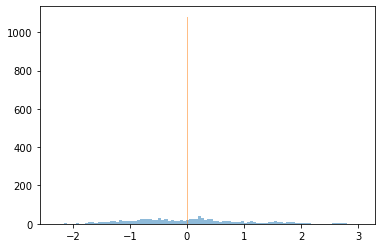

MSE 1.0000000006499572


In [7]:
Theta_trace = np.stack(Theta_trace,0)
Sigma_trace = np.stack(Sigma_trace,0)

Y_pred = np.dot(X_train, np.mean(Theta_trace, axis=0).reshape(-1,1)) + np.mean(Sigma_trace, axis=0)
plt.hist(Y_train, alpha=0.5, bins=100)
plt.hist(Y_pred, alpha=0.5, bins=100)
plt.show()

print('MSE', np.mean(np.square(Y_train-Y_pred)))

In [8]:
from scipy.stats import norm, expon, gamma

In [9]:
X_dummy = np.random.randn(100)
Y_dummy = X_dummy + 5 + np.random.randn(100)*0.2

# Y = N(theta*X+sigma)

def theta_prior(x, loc=0, scale=1):
    return norm.pdf(x, loc=loc, scale=scale)
def sigma_prior(x, loc=0, scale=1):
    return np.abs(norm.pdf(x, loc=loc, scale=scale))/2
def Q(pos, scale=0.5):
    return [norm(loc=pos[0], scale=scale).rvs(1)[0], norm(loc=pos[1], scale=scale).rvs(1)[0]]
def f(data, theta, sigma):
    # data -> (x,y)
    vals = norm.pdf(data[1], loc=theta*data[0], scale=sigma)
    return np.prod(vals)

def acceptance(prob, prob_new):
    if prob_new >= prob:
        return True
    ratio = prob_new/prob
    if np.random.uniform(0,1) <= ratio:
        return True
    else:
        return False

# MCMC !

n = int(3e4)
pos_trace = [[norm(loc=0, scale=1).rvs(1)[0], expon(scale=1).rvs(1)[0]]]
rejected = []
rejection_rates = []
scale = 0.44

for _ in tqdm(range(n)):
    p = f(data=[X_dummy, Y_dummy], theta=pos_trace[-1][0], sigma=pos_trace[-1][1])
    pos_new = Q(pos_trace[-1], scale=scale)
    p_new = f(data=[X_dummy, Y_dummy], theta=pos_new[0], sigma=pos_new[1])

    if acceptance(p, p_new):
        pos_trace.append(pos_new)
    else:
        rejected.append(pos_new)
    rt = round(len(rejected)/(len(pos_trace)+len(rejected)),3)
    rejection_rates.append(rt)

pos_trace = np.stack(pos_trace,0)

100%|██████████| 30000/30000 [00:37&lt;00:00, 796.00it/s]


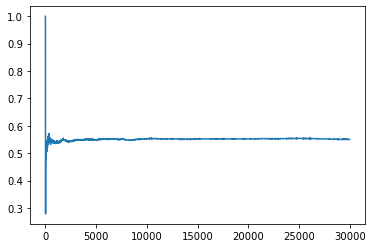

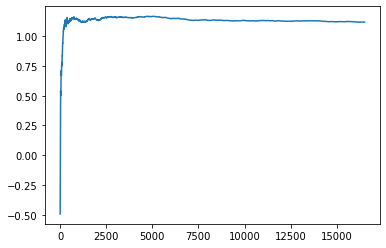

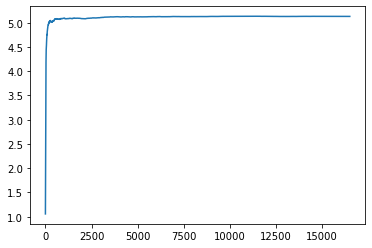

In [10]:
plt.plot([1-x for x in rejection_rates])
plt.show()
cummean_theta = np.cumsum(pos_trace[:,0])/np.arange(1,pos_trace.shape[0]+1)
plt.plot(cummean_theta)
plt.show()
cummean_sigma = np.cumsum(pos_trace[:,1])/np.arange(1,pos_trace.shape[0]+1)
plt.plot(cummean_sigma)
plt.show()

In [12]:
print('Theta estimate', np.mean(pos_trace[:,0]))
print('Sigma estimate', np.mean(pos_trace[:,1]))

Theta estimate 1.1168225080496823
Sigma estimate 5.129703983132738


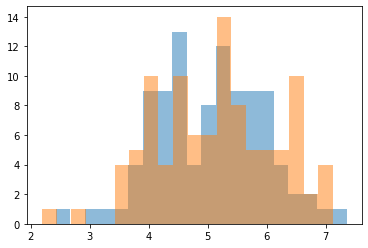

In [14]:
Y_pred = np.mean(pos_trace[:,0]) * X_dummy + np.mean(pos_trace[:,1])
plt.hist(Y_dummy, alpha=0.5, bins=20)
plt.hist(Y_pred, alpha=0.5, bins=20)
plt.show()

In [15]:
print('MSE', np.mean(np.square(Y_dummy-Y_pred)))

MSE 0.06335528851781078


In [17]:
X_min = np.min(X_dummy)
X_max = np.max(X_dummy)
Y_min = np.mean(pos_trace[:,0]) * X_min + np.mean(pos_trace[:,1])
Y_max = np.mean(pos_trace[:,0]) * X_max + np.mean(pos_trace[:,1])
plt.plot([X_min,X_max], [Y_min, Y_max], alpha=1, c='r', zorder=10)

for _ in range(1000):
    theta_sampled = norm(mu_theta, std_theta).rvs(1)[0]
    sigma_sampled = np.abs(norm(mu_sigma, std_sigma).rvs(1)[0])
    Y_min = theta_sampled * X_min + sigma_sampled
    Y_max = theta_sampled * X_max + sigma_sampled
    plt.plot([X_min,X_max], [Y_min, Y_max], alpha=0.01, c='r', zorder=0)

plt.scatter(X_dummy, Y_dummy, alpha=0.7, c='b', zorder=1)

plt.show()

NameError: name &#39;mu_theta&#39; is not defined

In [ ]:
# Generate competition submission

submission = []

for i in range(test_df.shape[0]):
    patient = test_df.values[i,0]
    X_pred = test_df[cols_X].iloc[i:i+1,:]

    for feat in ['Weeks', 'Percent', 'Age']:
        X_pred[feat] = (X_pred[feat].values - mu_norm[feat])/std_norm[feat]
    X_pred = X_pred.values.reshape(1,-1)

    X_pred = np.hstack([np.arange(-12,134).reshape(-1,1), np.repeat(X_pred[:, 1:], 146, axis=0)])
    Y_pred = (lin_reg.predict(X_pred)*std_norm['FVC'])+mu_norm['FVC']

    patient_submission = []
    for j, w in enumerate(np.arange(-12,134)):
        vals = np.array([w, patient+'_'+str(w), Y_pred[j], (std_linreg*std_norm['FVC'])+mu_norm['FVC']]).reshape(1,-1)
        vals = pd.DataFrame(vals, columns=['Week', 'Patient_Week', 'FVC', 'Confidence'])
        vals['Week'] = vals['Week'].astype(np.int32)
        vals['FVC'] = vals['FVC'].astype(np.float32)
        vals['Confidence'] = vals['Confidence'].astype(np.float32)
        patient_submission.append(vals)
    patient_submission = pd.concat(patient_submission)
    submission.append(patient_submission)

submission = pd.concat(submission)
submission.sort_values('Week', inplace=True)
submission.drop(['Week'], 1, inplace=True)

submission.head()
submission.to_csv('submission.csv', index=False)